In [1]:
# import
import pandas as pd
import random
import torch

from d2l import torch as d2l
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import transforms

In [2]:
# paths
ROOT_PATH = 'D:/Code/GitHub/d2l_learning/notes/data/classify-leaves/'
TRAIN_PATH = 'D:/Code/GitHub/d2l_learning/notes/data/classify-leaves/train.csv'
TEST_PATH = 'D:/Code/GitHub/d2l_learning/notes/data/classify-leaves/test.csv'

In [3]:
# dataset
class CLDataset(Dataset):
    def __init__(self):
        super().__init__()
        dataset = pd.read_csv(TRAIN_PATH)
        label_lst = list(set(dataset.label))
        label_idx = list(range(len(label_lst)))
        self.label_translator = dict(zip(label_idx + label_lst, label_lst + label_idx))
        self.images = list(dataset.image)
        self.labels = list(self.label_translator[label] for label in dataset.label)
        self.transform = transforms.Compose([transforms.ToTensor()])
    
    def __getitem__(self, index):
        img_path = ROOT_PATH + self.images[index]
        img = Image.open(img_path)
        return (self.transform(img), self.labels[index])
    
    def __len__(self):
        return len(self.images)
    
    def get_num_catagories(self):
        return len(self.label_translator) // 2

def get_data_iter(dataset, batch_size, split=False, seed=42):
    if not split:
        train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return (train_iter, None)
    n_dataset = len(dataset)
    n_valid = n_dataset // 5
    random.seed(seed)
    indices = list(range(n_dataset))
    random.shuffle(indices)
    print('Shuffle done!')
    train_sampler = SubsetRandomSampler(indices[n_valid:])
    valid_sampler = SubsetRandomSampler(indices[:n_valid])
    print('Sampler done!')
    train_iter = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    valid_iter = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    print('DLoader done!')
    return (train_iter, valid_iter)

In [4]:
# net
def get_AlexNet(num_catagories):
    net = nn.Sequential(nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2),
                        nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2),
                        nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
                        nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
                        nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2),
                        nn.Flatten(),
                        nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
                        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
                        nn.Linear(4096, num_catagories))
    return net

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

def get_ResNet(num_catagories):
    b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
    b3 = nn.Sequential(*resnet_block(64, 128, 2))
    b4 = nn.Sequential(*resnet_block(128, 256, 2))
    b5 = nn.Sequential(*resnet_block(256, 512, 2))
    
    net = nn.Sequential(b1, b2, b3, b4, b5,
                        nn.AdaptiveAvgPool2d((2, 2)),
                        nn.Flatten(),
                        nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
                        nn.Linear(1024, num_catagories))
    return net

In [5]:
dataset = CLDataset()
print(dataset[0][0].shape)

torch.Size([3, 224, 224])


In [6]:
num_catagories = dataset.get_num_catagories()
net = get_ResNet(num_catagories)
net.eval()
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
net.train()

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 2, 2])
Flatten output shape:	 torch.Size([1, 2048])
Linear output shape:	 torch.Size([1, 1024])
BatchNorm1d output shape:	 torch.Size([1, 1024])
ReLU output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 176])


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

loss 0.233, train acc 0.928, test acc 0.119
466.1 examples/sec on cuda:0


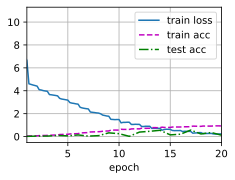

In [7]:
lr, num_epochs, batch_size = 1.0, 20, 128
train_iter, valid_iter = get_data_iter(dataset, batch_size, split=True)
d2l.train_ch6(net, train_iter, valid_iter, num_epochs, lr, d2l.try_gpu())